# Twitter analysis of climate change perceptions

In [1]:
# Import libraries
import config
import pandas as pd
import numpy as np
import itertools
import collections
from pprint import pprint
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.set_option('display.max_colwidth', -1)

# Text processing tools
import tweepy
from textblob import TextBlob, Word
import re, nltk, gensim, spacy
from nltk.corpus import stopwords
nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Visualization libraries
from geopy.geocoders import Nominatim
import gmplot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


sns.set(font_scale=1.5)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /home/ivana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Interacting with twitter's API
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret) 
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API (auth, wait_on_rate_limit = True) 

In [3]:
# Clean the tweets
def clean_tweet(tweet):
    """ Utility function to clean a tweet by removing 
    links and special characters using regex.

    Parameters
    ----------
    tweet : string
        A text string that you want to parse and remove special characters.

    Returns
    -------
    The same tweet string without special characters removed.
    """
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())   

In [4]:
# List of tweets related to climate change
search_words = ("#ClimateChange", "Environment", "climate", "climatechange", "environment")


def get_tweets_df(search_words):
    """Extracts tweets, finds sentiment score and returns tweets as a DataFrame 

    Parameters
    ----------
    search_words : list 
        A list of phrases to extract
    
    Returns
    -------
    Pandas DataFrame of tweets
    """
    res = []
    # Extract tweets for a given list of phrases
    for word in search_words:
        for tweet in tweepy.Cursor (api.search, 
                                    q = word + " -filter:retweets", 
                                    lang = "en").items(550):
            res.append(tweet)
   
    id_list = [tweet.id for tweet  in res]
    
    # Create tweets DataFrame
    data_set = pd.DataFrame(id_list, columns = ["id"])
    data_set["text"] = [tweet.text for tweet in res]
    data_set["len"]  = np.array([len(tweet.text) for tweet in res])
    data_set["created_at"] = [tweet.created_at for tweet in res]
    data_set["user_location"] = [tweet.author.location for tweet in res]
    data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in res]
    
    # Use clean function to remove special characters
    data_set["text"] = np.array([ clean_tweet(tweet) for tweet in data_set['text'] ])
    
    # Add Sentiment score and class
    text = data_set["text"]
    for i in range(0,len(text)):
        textB = TextBlob(text[i])
        sentiment = textB.sentiment.polarity

        data_set.at[i, 'sentiment'] = sentiment
        if sentiment <0.00:
            SentimentClass = 'Negative'
            data_set.at[i, 'sentiment_class'] = SentimentClass 
        elif sentiment >0.00:
            SentimentClass = 'Positive'
            data_set.at[i, 'sentiment_class']= SentimentClass 
        else:
            SentimentClass = 'Neutral'
            data_set.at[i, 'sentiment_class']= SentimentClass
    
    return data_set
    

In [5]:
# Create tweets DataFrame
tweets_df = get_tweets_df(search_words)
tweets_df.head()

,id,text,len,created_at,user_location,Hashtags,sentiment,sentiment_class
0,1181505154970988544,Let s do something about this ClimateChange SaveourPlanet,84,2019-10-08 09:42:34,"Birmingham, England","[{'text': 'ClimateChange', 'indices': [31, 45]}, {'text': 'SaveourPlanet', 'indices': [46, 60]}]",0.000000,Neutral
1,1181504950234427392,skynews quite amusing watching some of these woke young people Brexit means Brexit infuriates because,139,2019-10-08 09:41:46,,"[{'text': 'skynews', 'indices': [0, 8]}]",0.350000,Positive
2,1181504931892731904,ClimateChange ClimateAction ExtinctionRebellion SmithfieldMarket,139,2019-10-08 09:41:41,Sussex,"[{'text': 'ClimateChange', 'indices': [33, 47]}, {'text': 'ClimateAction', 'indices': [48, 62]}, {'text': 'ExtinctionRebellion', 'indices': [76, 96]}, {'text': 'SmithfieldMarket', 'indices': [97, 114]}]",0.000000,Neutral
3,1181504921482518528,Greta Thunberg X Fat Boy Slim Right Here Right Now ExtinctionRebellion GretaThunberg Trump ClimateChange,138,2019-10-08 09:41:39,,"[{'text': 'ExtinctionRebellion', 'indices': [56, 76]}, {'text': 'GretaThunberg', 'indices': [77, 91]}, {'text': 'Trump', 'indices': [92, 98]}, {'text': 'ClimateChange', 'indices': [99, 113]}]",0.285714,Positive
4,1181504902356520960,He s right We do need a government that will take ClimateChange se,140,2019-10-08 09:41:34,"Ontario, Canda","[{'text': 'ClimateChange', 'indices': [98, 112]}]",0.285714,Positive


In [6]:
# Number of collected tweets
tweets_df.count()

id                 2750
text               2750
len                2750
created_at         2750
user_location      2750
Hashtags           2750
sentiment          2750
sentiment_class    2750
dtype: int64

### Text clean up
To preprocess the tweets we will need to replace capital letters with lower case, remove stopwords and transform words to their base form.


In [7]:
# Create a list of lists containing lowercase words for each tweet
lower_tweets = [tweet.lower().split() for tweet in tweets_df.text] 
lower_tweets[:2]

[['let',
  's',
  'do',
  'something',
  'about',
  'this',
  'climatechange',
  'saveourplanet'],
 ['skynews',
  'quite',
  'amusing',
  'watching',
  'some',
  'of',
  'these',
  'woke',
  'young',
  'people',
  'brexit',
  'means',
  'brexit',
  'infuriates',
  'because']]

In [8]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in lower_tweets]
tweets_nsw[:2]

[['let', 'something', 'climatechange', 'saveourplanet'],
 ['skynews',
  'quite',
  'amusing',
  'watching',
  'woke',
  'young',
  'people',
  'brexit',
  'means',
  'brexit',
  'infuriates']]

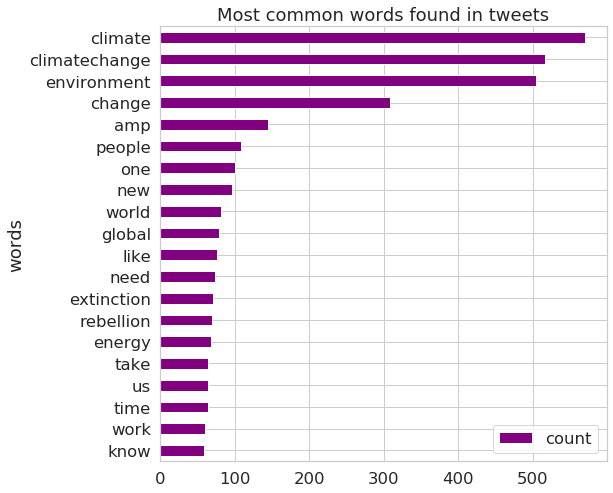

In [9]:
# Flatten list of words in clean tweets
all_words_nsw = list(itertools.chain(*tweets_nsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets")
plt.show()

In addition to removal of stopwords, we will also create a collection of our own topic related words. Since we have  used "climated change" as a collection term, this term appear in every collected tweet. Therefore, we can expect that these terms will dominate the list of the most frequent words. In order to obtain new insight into the perceptions of twitter users we remove the search words from tweets through list comprehension.

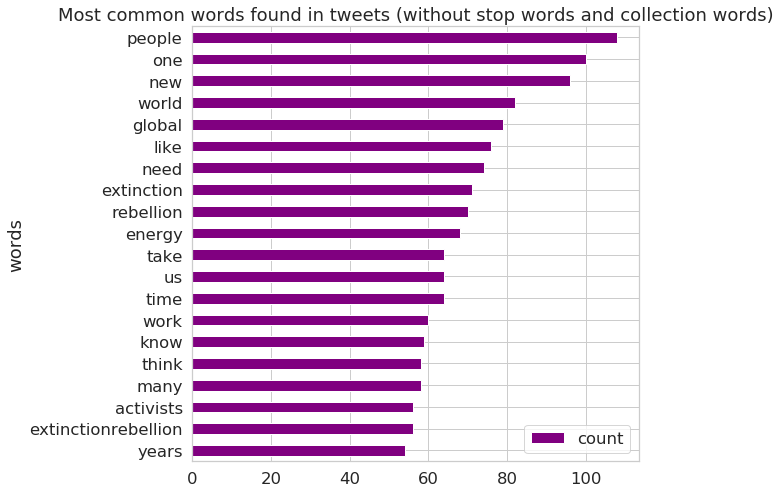

In [10]:
# Create a list of words to remove
remove_words = ("#ClimateChange", "Environment", "climate", "climatechange", "change", "amp", "much", "environment")

# Remove search words and rerun word frequency plot
tweets_nsw_rsw = [[w for w in word if not w in remove_words]
                  for word in tweets_nsw]

# Flatten list of words in clean tweets
all_words_nsw_rsw = list(itertools.chain(*tweets_nsw_rsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw_rsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets (without stop words and collection words)")
plt.show()

In next section I will explore the co-occuring words (bigrams) in the tweets. Analysis of bigrams provides deeper understanding compared to single words.

In [11]:
# Create a list of lists containing bigrams in tweets
tweet_bigrams = [list(nltk.bigrams(tweet)) for tweet in tweets_nsw_rsw]

# Display bigrams from the first tweet
tweet_bigrams[0]

[('let', 'something'), ('something', 'saveourplanet')]

In [12]:
# Display the original tweet 
tweets_df.text[0]

'Let s do something about this ClimateChange SaveourPlanet'

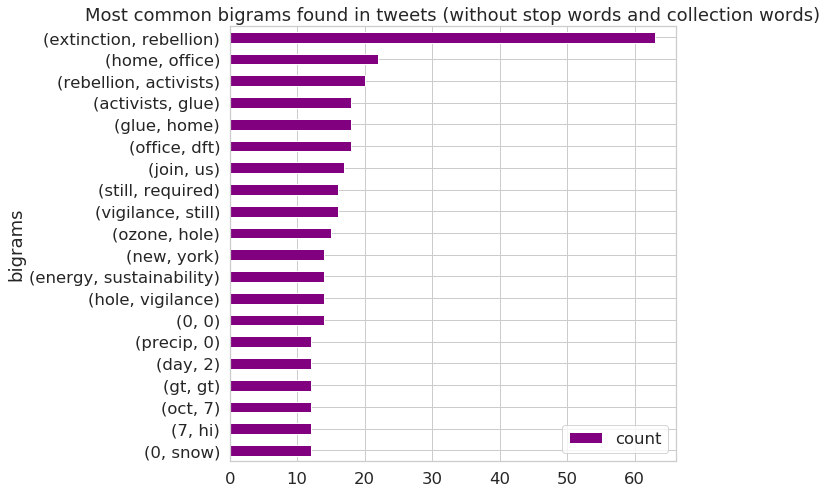

In [13]:
# Flatten list of bigrams
bigrams = list(itertools.chain(*tweet_bigrams))

# Create a counter of most frequent bigrams
bigrams_count = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigrams_count.most_common(20),
                         columns=['bigrams', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
bigram_df.sort_values(by='count').plot.barh(x='bigrams',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common bigrams found in tweets (without stop words and collection words)")
plt.show()

### Geospatial analysis
Next we will look at where are people tweeting from.

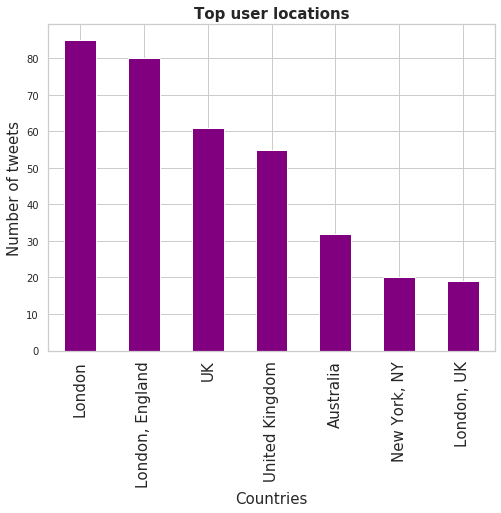

In [14]:
# Plot horizontal bar graph to see where majority of tweets are from
tweets_by_country = tweets_df['user_location'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top user locations',fontsize=15, fontweight='bold')
tweets_by_country[1:8].plot(ax=ax, kind='bar', color='purple')

To get better sense of where the majority of tweets are coming from we will use the user locations in text format such as "London, England" and transform it into latitude and longitude coordinates. Having the coordinates we can create a heatmap visualization.

In [15]:
# Plot user locations on heatmap
geoloc = Nominatim()


# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}  

for count, user_loc in enumerate(tweets_df.user_location):  
    try:
        location = geoloc.geocode(user_loc)
        

        # If coordinates are found for location append them and wait so the TimeOut Error is not raised
        if location:
            coordinates['latitude'].append(location.latitude)
            coordinates['longitude'].append(location.longitude)
            time.sleep(0.5)

    # If too many connection requests
    except:
        pass

# Instantiate and center a GoogleMapPlotter object to show our map
gmap = gmplot.GoogleMapPlotter(30, 0, 3)

# Insert points on the map passing a list of latitudes and longitudes
gmap.heatmap(coordinates['latitude'], coordinates['longitude'], radius=20)

# Save the map to html file
gmap.draw("vis/tweets_heatmap.html")

### Sentiment analysis
Sentiment analysis or otherwise known as opinion mining, looks at the emotional tone behind a series of words, used to gain an understanding of the the attitudes, opinions and emotions expressed within a text. Sentiment analysis is extremely useful in social media monitoring as it allows us to gain an overview of the wider public opinion behind the analysed topic. 

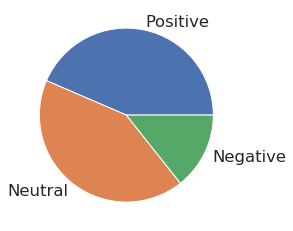

In [16]:
# Plot pie chart of sentiment classes
tweets_sentiment = tweets_df['sentiment_class'].value_counts()

# Create a pie chart
plt.pie(tweets_sentiment, labels=tweets_sentiment.index)
plt.show()

In [17]:
# Print descriptive statistics
tweets_df.sentiment.describe()

count    2750.000000
mean     0.100526   
std      0.258833   
min     -1.000000   
25%      0.000000   
50%      0.000000   
75%      0.225000   
max      1.000000   
Name: sentiment, dtype: float64

In [18]:
# Show the most positive tweet
tweets_df.text.loc[tweets_df['sentiment'].idxmax()]

'Day 2 of the rebellion So very proud of everyone in london yesterday and today Millions of people support what yo'

In [19]:
# Show the most positive tweet
tweets_df.text.loc[tweets_df['sentiment'].idxmin()]

'Bit of a stretch calling it food but as climatewarriors they shouldnt eat one of the worst contributors to ClimateChange'

### Topic modeling
Topic Modeling is a form of unsupervised learning used for identifying common “topics” in large clusters of texts.
Topics can be defined as a repeating pattern of co-occurring terms in a corpus.

To compare the agruments used by twitter users we will look at how the topics differ for positive and negative tweets. 

In [20]:
# Create a column of tweets excluding stopwords
tweets_df['clean_text']=tweets_nsw_rsw

# Create a list of positive and negative tweets
positive_tweets = tweets_df.clean_text.loc[tweets_df['sentiment_class'] == "Positive"]
negative_tweets = tweets_df.clean_text.loc[tweets_df['sentiment_class'] == "Negative"]

In [21]:
# Define a function which will lemmatize words. This will transfrom words to its base form
def lemmatization(tweets_nsw , allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """ Lemmetize tweets  

    Parameters
    ----------
    tweets_nsw : list 
        A list of tweets excluding stop words
    
    Returns
    -------
    List of lemmetized tweets
    """
    texts_out = []
    for tweet in tweets_nsw:
        doc = nlp(" ".join(tweet)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
positive_tweets_lemmatized = lemmatization(positive_tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
negative_tweets_lemmatized = lemmatization(negative_tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


print(negative_tweets_lemmatized[:2])

['steamdrill long cut heart inner working universe illuminate inequality', 'coal industry die coal less competitive electricity production']


In [22]:
# Tokenize each sentence into a list of words
def tweets_to_words(tweets):
    """ Tokenize tweets  

    Parameters
    ----------
    tweets : list 
        A list of tweets to tokenize
    
    Returns
    -------
    List of tokenized tweets
    """
    for sentence in tweets:
        yield(gensim.utils.simple_preprocess(str(sentence)))  

positive_tweets_words = list(tweets_to_words(positive_tweets_lemmatized))
negative_tweets_words = list(tweets_to_words(negative_tweets_lemmatized))


print(negative_tweets_words[:2])

[['steamdrill', 'long', 'cut', 'heart', 'inner', 'working', 'universe', 'illuminate', 'inequality'], ['coal', 'industry', 'die', 'coal', 'less', 'competitive', 'electricity', 'production']]


In [23]:
# Create Dictionaries
pos_id2word = corpora.Dictionary(positive_tweets_words)
neg_id2word = corpora.Dictionary(negative_tweets_words)

# Term Document Frequency
pos_corpus = [pos_id2word.doc2bow(text) for text in positive_tweets_words]
neg_corpus = [neg_id2word.doc2bow(text) for text in negative_tweets_words]

In [24]:
# Build LDA models
pos_lda_model = gensim.models.ldamodel.LdaModel(corpus=pos_corpus,
                                           id2word=pos_id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

neg_lda_model = gensim.models.ldamodel.LdaModel(corpus=neg_corpus,
                                           id2word=neg_id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



In [25]:
# Print the keywords in the topics
print("Terms in positive tweets")
pprint(pos_lda_model.print_topics())
print("\n","Terms in negative tweets")
pprint(neg_lda_model.print_topics())

Terms in positive tweets
[(0,
  '0.024*"first" + 0.019*"new" + 0.017*"many" + 0.016*"take" + 0.014*"global" '
  '+ 0.010*"go" + 0.009*"need" + 0.009*"come" + 0.008*"rebellion" + '
  '0.008*"water"'),
 (1,
  '0.018*"day" + 0.012*"right" + 0.012*"get" + 0.011*"safe" + 0.010*"could" + '
  '0.008*"actually" + 0.008*"create" + 0.008*"bring" + 0.008*"let" + '
  '0.008*"everyone"'),
 (2,
  '0.027*"good" + 0.017*"world" + 0.013*"people" + 0.012*"use" + 0.011*"clean" '
  '+ 0.011*"care" + 0.010*"also" + 0.010*"would" + 0.010*"think" + '
  '0.008*"power"'),
 (3,
  '0.024*"work" + 0.014*"see" + 0.013*"give" + 0.011*"love" + 0.009*"do" + '
  '0.009*"human" + 0.009*"issue" + 0.007*"look" + 0.007*"thank" + 0.006*"man"'),
 (4,
  '0.028*"make" + 0.013*"new" + 0.011*"action" + 0.010*"planet" + '
  '0.009*"protect" + 0.009*"well" + 0.007*"news" + 0.007*"moon" + 0.007*"co" + '
  '0.006*"take"')]

 Terms in negative tweets
[(0,
  '0.013*"global" + 0.012*"waste" + 0.011*"help" + 0.010*"take" + '
  '0.010*"

In [26]:
# Compute Coherence Score
pos_coherence_model = CoherenceModel(model=pos_lda_model, texts=positive_tweets_words, dictionary=pos_id2word, coherence='c_v')
pos_coherence_score = pos_coherence_model.get_coherence()
print('\nPositive tweets LDA Coherence Score: ', pos_coherence_score)

neg_coherence_model = CoherenceModel(model=neg_lda_model, texts=negative_tweets_words, dictionary=neg_id2word, coherence='c_v')
neg_coherence_score = neg_coherence_model.get_coherence()
print('\nNegative tweets LDA Coherence Score: ', neg_coherence_score)


Positive tweets LDA Coherence Score:  0.5955485168652364

Positive tweets LDA Coherence Score:  0.6355591163670071


### Hyperparameter tuning
The last step is to find the optimal number of topics. We will do it by running LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. 

In [30]:
def compute_coherence_score(dictionary, corpus, tweets, limit, start=2, step=2):
    """
    Compute coherence score for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    tweets : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tweets, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

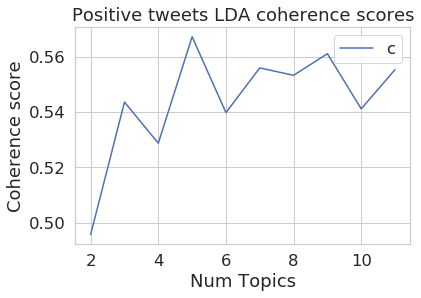

In [37]:
# Create the model lists and calculate coherece scores
pos_model_list, pos_coherence = compute_coherence_score(dictionary=pos_id2word, corpus=pos_corpus, tweets=positive_tweets_words, start=2, limit=12, step=1)

# Show graph
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, pos_coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Positive tweets LDA coherence scores")
plt.legend(("coherence_values"), loc='best')
plt.show()

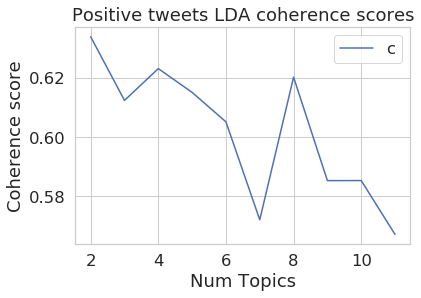

In [38]:
# Create the model lists and calculate coherece scores
neg_model_list, neg_coherence = compute_coherence_score(dictionary=neg_id2word, corpus=neg_corpus, tweets=negative_tweets_words, start=2, limit=12, step=1)

# Show graph
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, neg_coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Positive tweets LDA coherence scores")
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence score showed that the optimal number of topics are 4 for positive tweets and 6 for negative tweets.

In [52]:
# Build LDA models
pos_lda_best_model = gensim.models.ldamodel.LdaModel(corpus=pos_corpus,
                                           id2word=pos_id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

neg_lda_best_model = gensim.models.ldamodel.LdaModel(corpus=neg_corpus,
                                           id2word=neg_id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [53]:
# Compute Coherence Score
pos_coherence_model = CoherenceModel(model=pos_lda_best_model, texts=positive_tweets_words, dictionary=pos_id2word, coherence='c_v')
pos_coherence_score = pos_coherence_model.get_coherence()
print('\nPositive tweets LDA Coherence Score: ', pos_coherence_score)

neg_coherence_model = CoherenceModel(model=neg_lda_best_model, texts=negative_tweets_words, dictionary=neg_id2word, coherence='c_v')
neg_coherence_score = neg_coherence_model.get_coherence()
print('\nNegative tweets LDA Coherence Score: ', neg_coherence_score)


Positive tweets LDA Coherence Score:  0.6282143786548902

Negative tweets LDA Coherence Score:  0.6357901439127218


In [54]:
# Print the keywords in the topics
print("Terms in positive tweets")
pprint(pos_lda_best_model.print_topics())
print("\n","Terms in negative tweets")
pprint(neg_lda_best_model.print_topics())

Terms in positive tweets
[(0,
  '0.025*"global" + 0.015*"new" + 0.012*"talk" + 0.011*"many" + 0.011*"strong" '
  '+ 0.010*"big" + 0.010*"easy" + 0.009*"leader" + 0.009*"damage" + '
  '0.009*"understand"'),
 (1,
  '0.041*"first" + 0.029*"day" + 0.018*"planet" + 0.016*"could" + '
  '0.015*"protect" + 0.015*"great" + 0.014*"create" + 0.013*"get" + '
  '0.013*"country" + 0.012*"week"'),
 (2,
  '0.023*"new" + 0.021*"protest" + 0.016*"clean" + 0.016*"care" + '
  '0.012*"friendly" + 0.012*"water" + 0.012*"power" + 0.011*"come" + '
  '0.011*"rebellion" + 0.011*"extinction"'),
 (3,
  '0.035*"work" + 0.013*"do" + 0.013*"actually" + 0.012*"many" + 0.010*"true" '
  '+ 0.010*"thank" + 0.009*"issue" + 0.009*"man" + 0.009*"try" + '
  '0.008*"think"'),
 (4,
  '0.029*"good" + 0.020*"action" + 0.017*"important" + 0.016*"earth" + '
  '0.015*"also" + 0.015*"well" + 0.014*"kind" + 0.013*"moon" + 0.012*"join" + '
  '0.011*"long"'),
 (5,
  '0.028*"see" + 0.019*"world" + 0.018*"right" + 0.017*"safe" + 0.013*"